# Heart-Failure

__Import Statements__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import altair as alt

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    PolynomialFeatures
)

from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

__Reading Data__

In [2]:
data = pd.read_csv("../data/raw/heart_failure.csv")
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
    random_state=123
)
X_train, y_train = train_df.drop(columns=["DEATH_EVENT"]), train_df["DEATH_EVENT"]
X_test, y_test = test_df.drop(columns=["DEATH_EVENT"]), test_df["DEATH_EVENT"]

In [3]:
for dt in [X_train, X_test, y_train, y_test]:
    print(dt.shape)

(239, 12)
(60, 12)
(239,)
(60,)


In [4]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


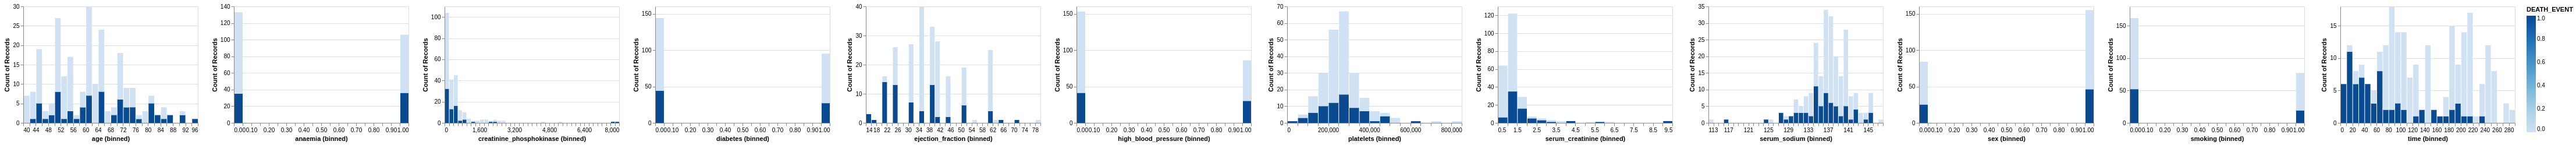

In [6]:
alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y="count()",
    color="DEATH_EVENT"
).properties(
    width=300,
    height=200
).repeat(
    X_train.columns.tolist()
)

In [7]:
numerical_features = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time"
]

categorical_features = [
    "anaemia",
    "diabetes",
    "high_blood_pressure",
    "sex",
    "smoking"
]

target_column = ["DEATH_EVENT"]

assert (
    len(numerical_features) +
    len(categorical_features)
) == len(X_train.columns)

In [8]:
for column in categorical_features + target_column:
    print(column)

    print(
        train_df[column].value_counts()
    )
    print("----------------")

anaemia
0    133
1    106
Name: anaemia, dtype: int64
----------------
diabetes
0    144
1     95
Name: diabetes, dtype: int64
----------------
high_blood_pressure
0    153
1     86
Name: high_blood_pressure, dtype: int64
----------------
sex
1    155
0     84
Name: sex, dtype: int64
----------------
smoking
0    162
1     77
Name: smoking, dtype: int64
----------------
DEATH_EVENT
0    168
1     71
Name: DEATH_EVENT, dtype: int64
----------------


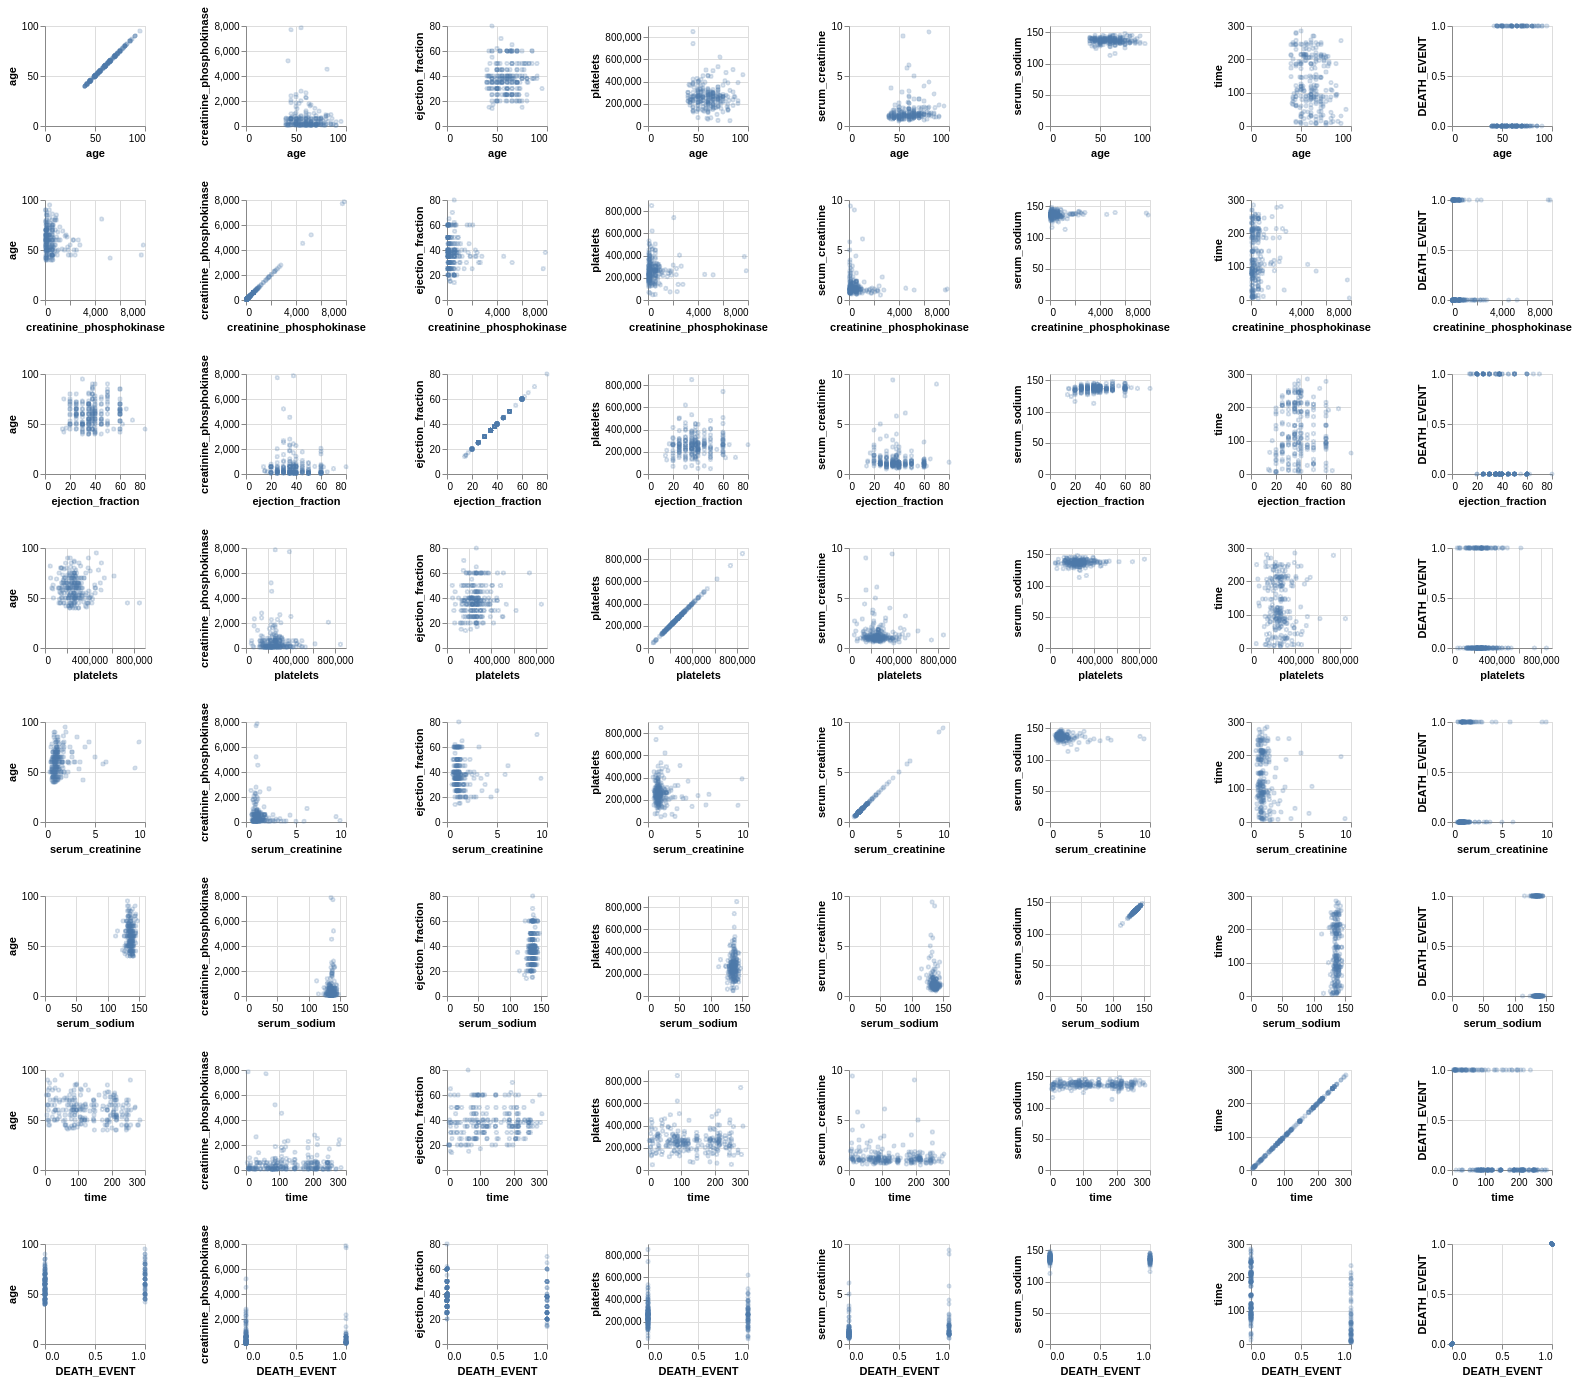

In [9]:
alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
    alt.X(alt.repeat("row"), type="quantitative"),
    alt.Y(alt.repeat("column"), type="quantitative")
).properties(
    width=100,
    height=100
).repeat(
    column=numerical_features + target_column,
    row=numerical_features + target_column
)

### Model

__Transformations__

In [36]:
column_transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    ("passthrough", categorical_features)
)

In [37]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'creatinine_phosphokinase',
                                  'ejection_fraction', 'platelets',
                                  'serum_creatinine', 'serum_sodium', 'time']),
                                ('passthrough', 'passthrough',
                                 ['anaemia', 'diabetes', 'high_blood_pressure',
                                  'sex', 'smoking'])])

In [38]:
pd.DataFrame(
    column_transformer.transform(X_train),
    columns=numerical_features + categorical_features
)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.236014,-0.462483,0.996022,-0.157978,-0.264903,2.569899,1.021205,0.0,0.0,1.0,1.0,0.0
1,1.654399,0.366978,-1.104660,-1.137308,-0.264903,1.666987,-0.567542,0.0,0.0,0.0,1.0,1.0
2,-1.274294,0.030509,-0.012305,-0.006053,-0.188589,0.086891,0.708664,0.0,1.0,1.0,0.0,0.0
3,0.817630,-0.515722,0.996022,0.860922,-0.360295,-0.590293,-1.127510,1.0,1.0,1.0,0.0,0.0
4,0.984984,-0.239945,-0.684524,3.531823,0.307450,0.312619,-0.554519,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
234,-0.437524,0.207262,0.575886,-0.009594,-0.074118,0.086891,-0.554519,0.0,0.0,0.0,1.0,0.0
235,1.570722,-0.530629,0.996022,-0.909787,0.402842,-0.816021,-0.684744,1.0,0.0,1.0,1.0,0.0
236,-1.274294,0.030509,-2.028961,-0.969140,-0.551079,-2.170389,-1.518185,0.0,0.0,0.0,1.0,0.0
237,-0.019140,-0.412439,-0.684524,-1.997932,0.307450,-2.170389,0.995160,0.0,0.0,0.0,0.0,0.0


__Base Models__

In [39]:
pipe_lr = make_pipeline(column_transformer, LogisticRegression(max_iter=10000))
pipe_dt = make_pipeline(column_transformer, DecisionTreeClassifier())
pipe_nb = make_pipeline(
   column_transformer,
#    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
   GaussianNB())
pipe_svc = make_pipeline(column_transformer, SVC())
pipe_rf = make_pipeline(column_transformer, RandomForestClassifier())
pipe_catboost = make_pipeline(column_transformer, CatBoostClassifier(verbose=False))

In [40]:
models = {
    "Logistic Regression": pipe_lr,
    "Decision Tree": pipe_dt,
    "NB": pipe_nb,
    "SVC": pipe_svc,
    "Random Forest": pipe_rf,
    "Cat boost": pipe_catboost,
}

In [41]:
scoring_metrics = [
    "accuracy",
    "roc_auc",
    "f1",
    "recall",
    "precision"
]

In [42]:
# Credits to Varada K.

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [43]:
results = {}

for name, value in models.items():
    print(f"Start {name}!")
    results[name] = mean_std_cross_val_scores(
        value, X_train, y_train, cv=10, return_train_score=True, scoring=scoring_metrics
    )
    print(f"Done {name}!")


Start Logistic Regression!
Done Logistic Regression!
Start Decision Tree!
Done Decision Tree!
Start NB!
Done NB!
Start SVC!
Done SVC!
Start Random Forest!
Done Random Forest!
Start Cat boost!
Done Cat boost!


In [44]:
pd.DataFrame(results)

,Logistic Regression,Decision Tree,NB,SVC,Random Forest,Cat boost
fit_time,0.008 (+/- 0.001),0.005 (+/- 0.001),0.004 (+/- 0.000),0.006 (+/- 0.001),0.108 (+/- 0.011),0.664 (+/- 0.069)
score_time,0.009 (+/- 0.002),0.007 (+/- 0.001),0.008 (+/- 0.001),0.008 (+/- 0.001),0.024 (+/- 0.003),0.025 (+/- 0.009)
test_accuracy,0.824 (+/- 0.077),0.757 (+/- 0.098),0.753 (+/- 0.084),0.816 (+/- 0.052),0.849 (+/- 0.089),0.836 (+/- 0.094)
train_accuracy,0.853 (+/- 0.011),1.000 (+/- 0.000),0.784 (+/- 0.013),0.901 (+/- 0.012),1.000 (+/- 0.000),0.999 (+/- 0.002)
test_roc_auc,0.860 (+/- 0.102),0.705 (+/- 0.119),0.823 (+/- 0.115),0.866 (+/- 0.088),0.910 (+/- 0.060),0.901 (+/- 0.063)
train_roc_auc,0.898 (+/- 0.010),1.000 (+/- 0.000),0.870 (+/- 0.011),0.959 (+/- 0.006),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1,0.673 (+/- 0.153),0.579 (+/- 0.170),0.450 (+/- 0.210),0.661 (+/- 0.105),0.722 (+/- 0.165),0.698 (+/- 0.185)
train_f1,0.735 (+/- 0.020),1.000 (+/- 0.000),0.556 (+/- 0.035),0.815 (+/- 0.024),1.000 (+/- 0.000),0.998 (+/- 0.003)
test_recall,0.636 (+/- 0.219),0.579 (+/- 0.219),0.368 (+/- 0.195),0.637 (+/- 0.222),0.680 (+/- 0.219),0.666 (+/- 0.240)
train_recall,0.689 (+/- 0.022),1.000 (+/- 0.000),0.457 (+/- 0.038),0.732 (+/- 0.034),1.000 (+/- 0.000),0.997 (+/- 0.007)


__Hyperparameter Tuning__

We will tune LR, Random Forest and CatBoost

#### Logistic Regression HPT

In [45]:
pipe_poly_lr = make_pipeline(
    column_transformer, PolynomialFeatures(), LogisticRegression(max_iter=10000)
)

params_poly_lr = {
    "logisticregression__class_weight": [None, "balanced"],
    "logisticregression__C": 10.0 ** np.arange(-2, 4),
    "polynomialfeatures__degree": [1, 2]
}

random_search_lr = RandomizedSearchCV(
    pipe_poly_lr,
    params_poly_lr,
    return_train_score=True,
    n_jobs=-1,
    scoring=scoring_metrics,
    refit="accuracy"
)

In [46]:
random_search_lr.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [47]:
pd.DataFrame(random_search_lr.cv_results_)[[
    "mean_fit_time",
    "param_logisticregression__class_weight",
    "param_logisticregression__C",
    "param_polynomialfeatures__degree",
    "mean_train_accuracy",
    "mean_test_accuracy",
    "mean_train_recall",
    "mean_test_recall",
    "mean_train_precision",
    "mean_test_precision",
    "mean_train_f1",
    "mean_test_f1"
]].sort_values("mean_test_recall", ascending=False).set_index("mean_test_recall").T

mean_test_recall,0.800000,0.730476,0.730476,0.730476,0.659048,0.546667,0.533333,0.505714,0.476190,0.308571
mean_fit_time,0.015065,0.038518,0.021504,0.018966,0.016131,0.041983,0.222553,0.038976,0.067219,0.018452
param_logisticregression__class_weight,balanced,balanced,balanced,balanced,None,None,balanced,None,None,None
param_logisticregression__C,0.01,100.0,10.0,1000.0,1000.0,1.0,1000.0,0.1,10.0,0.01
param_polynomialfeatures__degree,1,1,1,1,1,2,2,2,2,2
mean_train_accuracy,0.81797,0.811682,0.811682,0.811682,0.848309,0.939332,1.0,0.889103,0.987456,0.817986
mean_test_accuracy,0.80727,0.77367,0.777837,0.77367,0.83227,0.761082,0.681649,0.782092,0.702571,0.769858
mean_train_recall,0.813283,0.795677,0.795677,0.795677,0.686529,0.852318,1.0,0.707769,0.978947,0.394298
mean_train_precision,0.656612,0.649805,0.649805,0.649805,0.776094,0.938101,1.0,0.897209,0.978947,0.982476
mean_test_precision,0.664986,0.633279,0.642103,0.633279,0.750342,0.623853,0.464997,0.685882,0.504329,0.851429
mean_train_f1,0.726376,0.715309,0.715309,0.715309,0.728295,0.892721,1.0,0.790976,0.978947,0.562247


In [48]:
pipe_poly_lr_tuned = make_pipeline(
    column_transformer,
#     PolynomialFeatures(
#         degree=random_search_lr.best_params_["polynomialfeatures__degree"]
#     ),
    LogisticRegression(
        class_weight=random_search_lr.best_params_["logisticregression__class_weight"],
        C=random_search_lr.best_params_["logisticregression__C"],
        max_iter=10000
    )
)

In [49]:
pipe_poly_lr_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'time']),
                                                 ('passthrough', 'passthrough',
                                                  ['anaemia', 'diabetes',
                                                   'high_blood_pressure', 'sex',
                                                   'smoking'])])),
                ('logisticregression',
                 LogisticRegression(C=1000.0, max_iter=10000))])

In [50]:
# Credits to Varada K.

def plot_roc_curve(model, X, y):
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")

    default_threshold = np.argmin(np.abs(thresholds - 0.5))

    plt.plot(
        fpr[default_threshold],
        tpr[default_threshold],
        "or",
        markersize=10,
        label="threshold 0.5",
    )
    plt.legend(loc="best");

In [51]:
# Credits to Varada K.

def plot_PR_curve(
    precision,
    recall,
    close_default,
    label="PR curve",
    marker_colour="r",
    marker_label="Default threshold",
):
    plt.plot(precision, recall, label=label)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.plot(
        precision[close_default],
        recall[close_default],
        "o",
        markersize=12,
        label=marker_label,
        c=marker_colour,
    )
    plt.legend(loc="best");

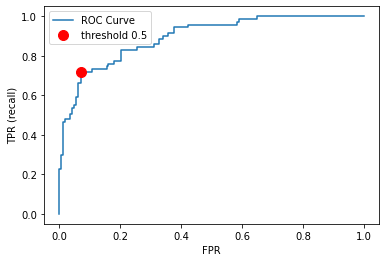

In [52]:
plot_roc_curve(pipe_poly_lr_tuned, X_train, y_train)

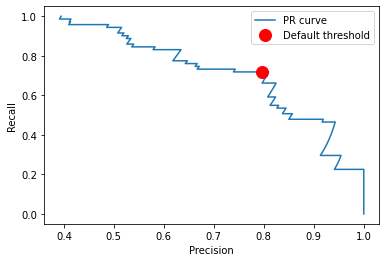

In [53]:
precision_avg, recall_avg, thresholds_avg = precision_recall_curve(
    y_train, pipe_poly_lr_tuned.predict_proba(X_train)[:, 1]
)

close_default_avg = np.argmin(np.abs(thresholds_avg - 0.5))

plot_PR_curve(precision_avg, recall_avg, close_default_avg)

In [54]:
feat_imp = pd.DataFrame(
    pipe_poly_lr_tuned.named_steps["logisticregression"].coef_,
    columns=numerical_features + categorical_features
).T
feat_imp
feat_imp["abs_coef"] = abs(feat_imp[0])
feat_imp.sort_values("abs_coef", ascending=False)

,0,abs_coef
time,-1.754729,1.754729
ejection_fraction,-0.850847,0.850847
age,0.603350,0.603350
sex,-0.592086,0.592086
serum_creatinine,0.579582,0.579582
smoking,-0.463829,0.463829
serum_sodium,-0.399806,0.399806
anaemia,-0.141123,0.141123
platelets,-0.132416,0.132416
creatinine_phosphokinase,0.118209,0.118209


#### SVC HPT

In [55]:
pipe_poly_svc = make_pipeline(
    column_transformer, PolynomialFeatures(), SVC()
)

params_poly_svc = {
    "svc__class_weight": [None, "balanced"],
    "svc__C": 10.0 ** np.arange(-2, 4),
    "svc__kernel": ["linear", "poly", "rbf"],
    "polynomialfeatures__degree": [1, 2]
}

random_search_svc = RandomizedSearchCV(
    pipe_poly_svc,
    params_poly_svc,
    return_train_score=True,
    n_jobs=-1,
    n_iter=20,
    scoring=scoring_metrics,
    refit="accuracy"
)

In [56]:
random_search_svc.fit(X_train, y_train)

/home/utkarshsaboo45/miniconda3/envs/env_heart-failure/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_heart-failure/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_heart-failure/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [57]:
pd.DataFrame(random_search_svc.cv_results_)[[
    "mean_fit_time",
    "param_svc__class_weight",
    "param_svc__C",
    "param_svc__kernel",
    "param_polynomialfeatures__degree",
    "mean_train_accuracy",
    "mean_test_accuracy",
    "mean_train_recall",
    "mean_test_recall",
    "mean_train_precision",
    "mean_test_precision",
    "mean_train_f1",
    "mean_test_f1"
]].sort_values("mean_test_recall", ascending=False).set_index("mean_test_recall").T

mean_test_recall,0.800000,0.786667,0.786667,0.674286,0.630476,0.589524,0.575238,0.547619,0.535238,0.535238,0.519048,0.519048,0.478095,0.252381,0.054286,0.054286,0.040952,0.040952,0.000000,0.000000
mean_fit_time,0.011269,0.476711,0.08376,0.875382,0.012699,0.012126,0.011291,0.031978,0.010681,0.014435,0.014677,0.012246,0.013462,0.012462,0.011581,0.018091,0.012556,0.015626,0.014879,0.010817
param_svc__class_weight,balanced,balanced,balanced,None,balanced,None,balanced,None,balanced,balanced,balanced,None,None,None,None,balanced,balanced,None,None,None
param_svc__C,0.01,1000.0,100.0,1000.0,10.0,0.1,1000.0,100.0,100.0,1000.0,100.0,1000.0,10.0,10.0,0.01,0.1,0.01,0.01,0.1,0.01
param_svc__kernel,rbf,linear,linear,linear,rbf,linear,rbf,linear,rbf,rbf,poly,poly,rbf,poly,poly,poly,poly,poly,rbf,rbf
param_polynomialfeatures__degree,1,1,1,1,1,1,1,2,2,2,1,1,2,2,2,2,2,1,2,2
mean_train_accuracy,0.378321,0.824236,0.823189,0.855645,0.976996,0.850414,1.0,1.0,1.0,1.0,1.0,1.0,0.961278,0.853556,0.724891,0.736398,0.724891,0.720708,0.702929,0.702929
mean_test_accuracy,0.377926,0.790426,0.790426,0.832447,0.77828,0.819858,0.744681,0.690071,0.753191,0.753191,0.736348,0.740514,0.765514,0.748936,0.715426,0.711259,0.707092,0.715426,0.702926,0.702926
mean_train_recall,0.8,0.813158,0.813158,0.676065,0.996491,0.647932,1.0,1.0,1.0,1.0,1.0,1.0,0.890852,0.507206,0.073872,0.112657,0.073872,0.059774,0.0,0.0
mean_train_precision,0.237696,0.669401,0.667795,0.807447,0.931533,0.810952,1.0,1.0,1.0,1.0,1.0,1.0,0.977061,1.0,1.0,1.0,1.0,1.0,0.0,0.0
mean_test_precision,0.2375,0.644231,0.644231,0.740476,0.650993,0.759217,0.581891,0.486199,0.603791,0.603791,0.589322,0.597014,0.709408,0.744444,0.35,0.35,0.233333,0.4,0.0,0.0


In [58]:
pipe_poly_svc_tuned = make_pipeline(
    column_transformer,
    PolynomialFeatures(
        degree=random_search_svc.best_params_["polynomialfeatures__degree"]
    ),
    SVC(
        class_weight=random_search_svc.best_params_["svc__class_weight"],
        C=random_search_svc.best_params_["svc__C"],
        kernel=random_search_svc.best_params_["svc__kernel"],
        probability=True
    )
)

In [59]:
pipe_poly_svc_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'time']),
                                                 ('passthrough', 'passthrough',
                                                  ['anaemia', 'diabetes',
                                                   'high_blood_pressure', 'sex',
                                                   'smoking'])])),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('svc', SVC(C=100

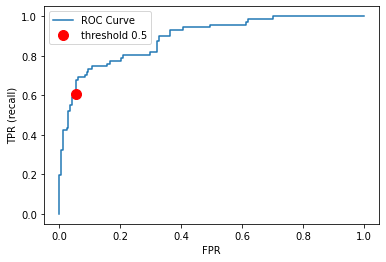

In [60]:
plot_roc_curve(pipe_poly_svc_tuned, X_train, y_train)

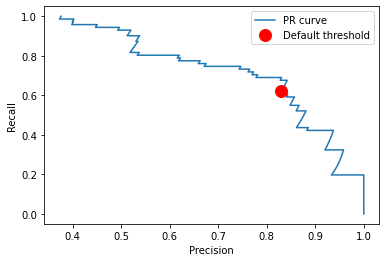

In [61]:
precision_avg, recall_avg, thresholds_avg = precision_recall_curve(
    y_train, pipe_poly_svc_tuned.predict_proba(X_train)[:, 1]
)

close_default_avg = np.argmin(np.abs(thresholds_avg - 0.5))

plot_PR_curve(precision_avg, recall_avg, close_default_avg)

#### Random Forest HPT

In [62]:
pipe_rf = make_pipeline(
    column_transformer, RandomForestClassifier()
)

params_rf = {
    "randomforestclassifier__class_weight": [None, "balanced", "balanced_subsample"],
    "randomforestclassifier__n_estimators": [50, 100, 150, 200],
    "randomforestclassifier__max_depth": [2, 3, 4, 5],
    "randomforestclassifier__criterion": ["gini", "entropy"],
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    params_rf,
    return_train_score=True,
    n_jobs=-1,
    n_iter=20,
    scoring=scoring_metrics,
    refit="accuracy"
)

In [63]:
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [64]:
pd.DataFrame(random_search_rf.cv_results_)[[
    "mean_fit_time",
    "param_randomforestclassifier__class_weight",
    "param_randomforestclassifier__n_estimators",
    "param_randomforestclassifier__max_depth",
    "param_randomforestclassifier__criterion",
    "mean_train_accuracy",
    "mean_test_accuracy",
    "mean_train_recall",
    "mean_test_recall",
    "mean_train_precision",
    "mean_test_precision",
    "mean_train_f1",
    "mean_test_f1"
]].sort_values("mean_test_recall", ascending=False).set_index("mean_test_recall").T

mean_test_recall,0.774286,0.745714,0.745714,0.731429,0.731429,0.731429,0.717143,0.702857,0.702857,0.702857,0.688571,0.674286,0.674286,0.660000,0.660000,0.645714,0.631429,0.589524,0.577143,0.576190
mean_fit_time,0.453282,0.336026,0.178808,0.491042,0.35478,0.216761,0.266172,0.254995,0.230802,0.141237,0.370569,0.101976,0.280317,0.385156,0.180112,0.101302,0.367495,0.170441,0.110761,0.232191
param_randomforestclassifier__class_weight,balanced_subsample,balanced,balanced,balanced_subsample,balanced_subsample,balanced_subsample,balanced,balanced_subsample,balanced_subsample,balanced_subsample,None,balanced,balanced,None,None,None,None,None,None,None
param_randomforestclassifier__n_estimators,200,200,100,200,150,100,150,100,100,50,200,50,150,200,100,50,200,100,50,100
param_randomforestclassifier__max_depth,2,2,2,4,3,3,2,4,5,4,5,5,5,3,5,5,4,3,3,3
param_randomforestclassifier__criterion,gini,entropy,gini,entropy,entropy,gini,gini,entropy,gini,entropy,gini,gini,entropy,gini,entropy,entropy,gini,gini,gini,entropy
mean_train_accuracy,0.893297,0.896433,0.897475,0.943515,0.912107,0.916301,0.894334,0.94561,0.969655,0.93618,0.948724,0.965472,0.962325,0.908982,0.944552,0.942463,0.924678,0.906894,0.904805,0.902694
mean_test_accuracy,0.874202,0.874202,0.85727,0.861525,0.853103,0.853191,0.849113,0.849025,0.861613,0.869858,0.865691,0.84477,0.85727,0.874202,0.861613,0.857535,0.861702,0.844947,0.845124,0.853457
mean_train_recall,0.799436,0.792356,0.806391,0.873246,0.831078,0.845113,0.79599,0.883835,0.929574,0.873183,0.834461,0.911967,0.90495,0.735902,0.820426,0.81698,0.774749,0.732393,0.725313,0.721805
mean_train_precision,0.835388,0.849452,0.8427,0.933215,0.867277,0.869707,0.840216,0.930307,0.967189,0.911114,0.992,0.970715,0.966535,0.947108,0.991556,0.987315,0.965386,0.943887,0.942081,0.93698
mean_test_precision,0.823504,0.826751,0.772506,0.795221,0.777179,0.77641,0.785664,0.792726,0.816667,0.831585,0.830303,0.785205,0.822288,0.901429,0.861111,0.853298,0.878247,0.849913,0.891429,0.909524


#### CatBoost HPT

In [76]:
pipe_cb = make_pipeline(
    column_transformer, CatBoostClassifier(verbose=False)
)

params_cb = {
    "catboostclassifier__auto_class_weights": ["SqrtBalanced", "Balanced"],
    "catboostclassifier__iterations": [100, 150, 200],
    "catboostclassifier__learning_rate": [0.03, 0.1],
    "catboostclassifier__depth": [2, 4, 6, 8],
    "catboostclassifier__l2_leaf_reg": [0.2, 0.5, 1, 3]
}

random_search_cb = RandomizedSearchCV(
    pipe_cb,
    params_cb,
    return_train_score=True,
    n_jobs=-1,
    n_iter=20,
    scoring=scoring_metrics,
    refit="accuracy"
)

In [77]:
random_search_cb.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [84]:
pd.DataFrame(random_search_cb.cv_results_)[[
    "mean_fit_time",
    "param_catboostclassifier__auto_class_weights",
    "param_catboostclassifier__iterations",
    "param_catboostclassifier__learning_rate",
    "param_catboostclassifier__depth",
    "param_catboostclassifier__l2_leaf_reg",
    "mean_train_accuracy",
    "mean_test_accuracy",
    "mean_train_recall",
    "mean_test_recall",
    "mean_train_precision",
    "mean_test_precision",
    "mean_train_f1",
    "mean_test_f1"
]].sort_values("mean_test_recall", ascending=False).set_index("mean_test_recall").T

mean_test_recall,0.788571,0.774286,0.774286,0.774286,0.760000,0.745714,0.745714,0.731429,0.731429,0.688571,0.688571,0.674286,0.674286,0.660952,0.660000,0.660000,0.660000,0.645714,0.645714,0.631429
mean_fit_time,0.365412,0.292382,0.537819,0.545459,0.619219,1.137899,0.373302,0.513668,0.698761,0.979378,2.635331,0.882117,1.785201,1.252527,0.914576,2.948837,0.614146,3.353823,1.592986,3.781578
param_catboostclassifier__auto_class_weights,Balanced,Balanced,Balanced,Balanced,Balanced,Balanced,Balanced,SqrtBalanced,SqrtBalanced,Balanced,Balanced,SqrtBalanced,Balanced,SqrtBalanced,SqrtBalanced,Balanced,Balanced,Balanced,Balanced,SqrtBalanced
param_catboostclassifier__iterations,150,100,200,200,150,150,100,200,200,200,150,200,100,100,200,200,150,200,200,200
param_catboostclassifier__learning_rate,0.1,0.1,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.1,0.03,0.1,0.1,0.03,0.03,0.1,0.03,0.03,0.03
param_catboostclassifier__depth,2,2,2,2,4,6,4,2,2,4,8,4,8,8,4,8,4,8,6,8
param_catboostclassifier__l2_leaf_reg,3,3,1,3,1,1,3,3,1,1,1,3,1,0.2,0.2,1,0.2,0.5,0.5,1
mean_train_accuracy,0.926772,0.910035,0.917337,0.912107,0.919432,0.959195,0.892239,0.921526,0.919432,0.98954,1.0,0.985351,1.0,1.0,1.0,1.0,0.998953,1.0,1.0,1.0
mean_test_accuracy,0.828014,0.83227,0.840603,0.832181,0.836348,0.84477,0.85727,0.85727,0.849025,0.83227,0.831915,0.840603,0.819415,0.840426,0.836348,0.832092,0.819681,0.828103,0.827926,0.840691
mean_train_recall,0.936717,0.897932,0.915476,0.904825,0.911967,0.978822,0.817043,0.827444,0.838033,1.0,1.0,0.978885,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean_train_precision,0.836944,0.817628,0.825696,0.818676,0.832956,0.894162,0.821106,0.900167,0.885039,0.966152,1.0,0.97217,1.0,1.0,1.0,1.0,0.996552,1.0,1.0,1.0
